Step 1: Clone the Python client repository

In [3]:
!git clone https://github.com/ICESat2-SlideRule/sliderule-python.git

fatal: destination path 'sliderule-python' already exists and is not an empty directory.


Step 2: Create a conda environment with all the necessary dependencies

In [4]:
!cd sliderule-python
!conda env create -f environment.yml


EnvironmentFileNotFound: '/home/jovyan/coastal_topobathy/SlideRule/environment.yml' file not found



Step 3: Install all packages

In [1]:
# import numpy as np
# import time
# from datetime import datetime, timedelta
# import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt
# from pyproj import Transformer, CRS
# from shapely.geometry import Polygon, Point
# from sliderule import sliderule
from sliderule import icesat2
# from pyproj import Transformer, CRS
# import requests
# import ipyleaflet
from ipyleaflet import Map, GeoData, LayersControl,Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon

In [ ]:
import sys
sys.path.append('../')

In [ ]:
from coastal.beam import reduce_dataframe
from coastal.plot import plot_atl08, plot_yapc

Step 4: Initialize the icesat2 package

In [2]:
icesat2.init("icesat2sliderule.org", verbose=True)

Step 5: Create a list of coordinates that represent the White Mountain, Alaska region of interest.

In [5]:
# import the map.geojson file representing the ROI
spatialExtent = icesat2.toregion('map.geojson')["poly"]

In [6]:
# check the format of the coordinates
spatialExtent

[{'lon': -162.75421142578125, 'lat': 64.34823209154665},
 {'lon': -162.77893066406247, 'lat': 64.54607936653424},
 {'lon': -163.3062744140625, 'lat': 64.79518717004242},
 {'lon': -163.69903564453122, 'lat': 64.69910544204765},
 {'lon': -163.16619873046875, 'lat': 64.4064312702572},
 {'lon': -162.75421142578125, 'lat': 64.34823209154665}]

In [7]:
# create bounding box
bb = [spatialExtent[0]['lon'], spatialExtent[0]['lat'], 
      spatialExtent[2]['lon'], spatialExtent[2]['lat']]

# create polygon for plotting
polygon = Polygon(
    locations=spatialExtent,
    color="green"
)

Visualize region of interest

In [11]:
center = [spatialExtent[0]['lat'], spatialExtent[0]['lon']]
zoom = 8
m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
m.add_layer(polygon);
m

Map(center=[64.34823209154665, -162.75421142578125], controls=(ZoomControl(options=['position', 'zoom_in_text'…

Step 4: Create a dictionary of processing parameters specifying how the elevations for the region should be calculated.

In [12]:
%%time

# build sliderule parameters for ATL03 subsetting request
# SRT_LAND = 0
# SRT_OCEAN = 1
# SRT_SEA_ICE = 2
# SRT_LAND_ICE = 3
# SRT_INLAND_WATER = 4
parms = {
    # processing parameters
    "srt": icesat2.SRT_LAND,
    "len": 20,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": -2, 
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
}

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.06 µs


Set the data asset, release and time boundaries for query

In [13]:
# Set ICESat-2 data asset
asset = "nsidc-s3"

# ICESat-2 data release
release = '005'

# time bounds for CMR query
time_start = '2019-07-10'
time_end = '2019-07-20'

Find the granules, create an empty geodataframe and write the query into the geodataframe

In [14]:
# find granule for each region of interest
granules_list = icesat2.cmr(polygon=spatialExtent, time_start=time_start, time_end=time_end, version=release)

# create an empty geodataframe
parms["poly"] = spatialExtent

# write output into geodataframe
gdf = icesat2.atl03sp(parms, asset=asset, version=release, resources=granules_list)

INFO:sliderule.icesat2:Allocating 21 workers across 7 processing nodes
INFO:sliderule.icesat2:0 points returned for ATL03_20190710014600_01830405_005_01.h5 (1 out of 3 resources)
INFO:sliderule.icesat2:1361414 points returned for ATL03_20190714013741_02440405_005_01.h5 (2 out of 3 resources)
INFO:sliderule.icesat2:874960 points returned for ATL03_20190718012923_03050405_005_01.h5 (3 out of 3 resources)


In [15]:
# look at the resulting geodataframe
gdf.head()

,track,segment_dist,rgt,sc_orient,segment_id,cycle,yapc_score,atl08_class,delta_time,quality_ph,atl03_cnf,height,distance,pair,geometry
time,,,,,,,,,,,,,,,
2019-07-14 01:41:43.864015240,3,1.286611e+07,244,0,642346,4,0,4,4.830370e+07,0,0,167.423950,-8.519688,0,POINT (-162.95389 64.62952)
2019-07-14 01:41:43.864015240,3,1.286611e+07,244,0,642346,4,24,4,4.830370e+07,0,0,-271.506531,3.715942,0,POINT (-162.95393 64.62941)
2019-07-14 01:41:43.864015240,3,1.286611e+07,244,0,642346,4,0,4,4.830370e+07,0,0,-0.217391,-3.846664,0,POINT (-162.95390 64.62948)
2019-07-14 01:41:43.864015240,3,1.286611e+07,244,0,642346,4,0,4,4.830370e+07,0,0,-187.967499,1.387081,0,POINT (-162.95392 64.62943)
2019-07-14 01:41:43.864015240,3,1.286611e+07,244,0,642346,4,0,4,4.830370e+07,0,0,-216.398285,2.179764,0,POINT (-162.95393 64.62943)


We will plot the Reference Grount Tracks separately. 

The RGT is an imaginary line through the six-beam pattern that is handy for getting a sense of where 
the orbits fall on Earth, and which the mission uses to point the observatory.

For more information see the ICESat-2 description [here]("https://icesat-2.gsfc.nasa.gov/science/specs").

In [16]:
# get unique RGTs
rgtValues = gdf['rgt'].unique()
rgtValues.sort()
print(rgtValues)

[244 305]


Plot the output by RGT track within the region of interest ## FIX TO SHOW RGT

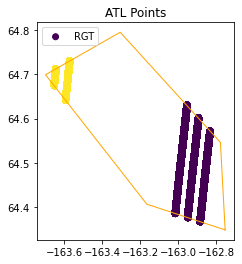

In [12]:
f, ax = plt.subplots()
ax.set_title("ATL Points")
ax.set_aspect('equal')
# FIX THIS TO SHOW EACH RGT value by color
gdf.plot(ax=ax, column='rgt', label="RGT")
ax.legend(loc="upper left")
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in whiteMountain]
region_lat = [e["lat"] for e in whiteMountain]
ax.plot(region_lon, region_lat, linewidth=1, color='orange');

In [19]:
geo_data = GeoData(geo_dataframe = gdf.sample(n=1000, replace=False, random_state=1),
#    style={'color': 'red', 'radius':1, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    style={'color': 'red', 'radius':1},
#    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
#    point_style={'radius': 1, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    point_style={'radius': 1, 'color': 'red', 'fillOpacity': 0.8},
    name = 'rgt')
m2 = m
m2.add_layer(geo_data)

In [20]:
m2

Map(bottom=17533.0, center=[64.34823209154665, -162.75421142578125], controls=(ZoomControl(options=['position'…

Reduce GeoDataFrame to plot a single beam and convert coordinate reference system to compound projection

In [27]:
print('cycle', gdf['cycle'].unique())
print('track', gdf['track'].unique())
print('rgt', gdf['rgt'].unique())

cycle [4]
track [3 2 1]
rgt [244 305]


In [35]:
beam_type = 'strong'
project_srs = "EPSG:26912+EPSG:5703"
D3 = reduce_dataframe(gdf, cycle=4, rgt=305, track=2, beam='strong', crs=project_srs)

In [36]:
D3["atl08_class"].value_counts()

4    150263
0        41
Name: atl08_class, dtype: int64

Plot ATL08 Classifications

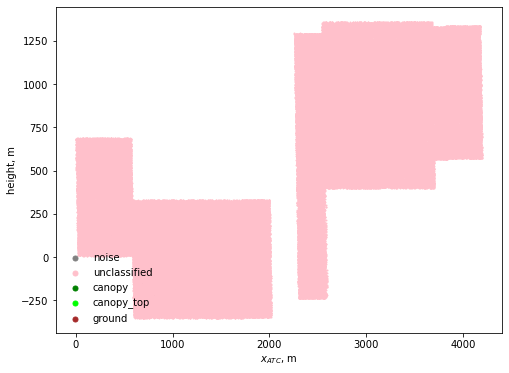

In [37]:
plot_atl08(D3)

Plot YAPC

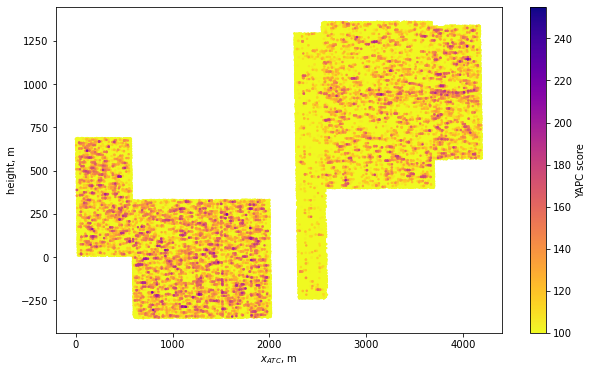

In [39]:
plot_yapc(D3)

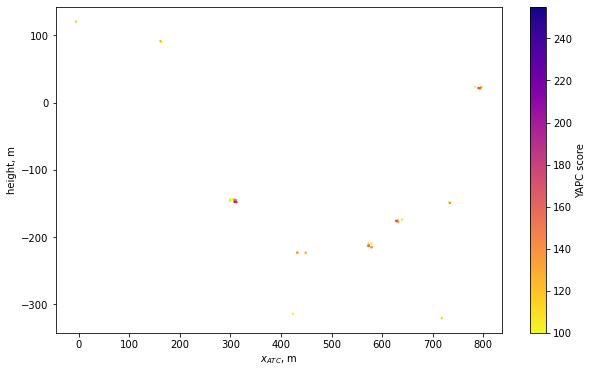

In [40]:
plot_yapc(D3[D3["atl08_class"] != 4])
